In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("../")

In [2]:
from __future__ import annotations

import os
import numpy as np

from src.mesoscaler.core import Mesoscale, make_independent, P0, DependentDataset
from src.mesoscaler.enums import (
    DependentVariables,
    # - dependent variables
    URMA,
    ERA5,
    # - independent variables
    Dimensions,
    Coordinates,
    X,
    Y,
    Z,
    T,
    LAT,
    LON,
    LVL,
    TIME,
    COORDINATES,
    DIMENSIONS,
    # Era5
    GEOPOTENTIAL,
    SPECIFIC_HUMIDITY,
    TEMPERATURE,
    U_COMPONENT_OF_WIND,
    V_COMPONENT_OF_WIND,
    VERTICAL_VELOCITY,
    # Urma
    SURFACE_PRESSURE,
    TEMPERATURE_2M,
    SPECIFIC_HUMIDITY_2M,
    # DEWPOINT_TEMPERATURE_2M,
    U_WIND_COMPONENT_10M,
    V_WIND_COMPONENT_10M,
    CEILING,
    TOTAL_CLOUD_COVER,
    WIND_SPEED_10M,
    WIND_SPEED_GUST,
    WIND_DIRECTION_10M,
    SURFACE_PRESSURE,
    VISIBILITY,
)

_test_data = "../tests/data"

urma_store = os.path.join(_test_data, "urma.zarr")
urma_dvars = list(URMA)

era5_store = os.path.join(_test_data, "era5.zarr")
era5_dvars = list(ERA5)
print(DIMENSIONS)
print(era5_dvars, urma_dvars, sep="\n")

(T, Z, Y, X)
[geopotential, specific_humidity, temperature, u_component_of_wind, v_component_of_wind, vertical_velocity]
[total_cloud_cover, ceiling, u_wind_component_10m, v_wind_component_10m, wind_speed_10m, wind_speed_gust, wind_direction_10m, temperature_2m, dewpoint_temperature_2m, specific_humidity_2m, surface_pressure, visibility, orography]


In [9]:
from typing import Any

Index = slice | int
# define the variables and levels

pressure_levels = [P0, 1000.0, 925.0, 850.0, 700.0, 500.0, 300.0]
era5_vars = [
    GEOPOTENTIAL,
    SPECIFIC_HUMIDITY,
    TEMPERATURE,
    U_COMPONENT_OF_WIND,
    V_COMPONENT_OF_WIND,
]
urma_vars = [
    SURFACE_PRESSURE,
    TEMPERATURE_2M,
    SPECIFIC_HUMIDITY_2M,
    U_WIND_COMPONENT_10M,
    V_WIND_COMPONENT_10M,
]

scale = Mesoscale(200, 200, pressure=pressure_levels, rate=20)  # acreate scale object
era5 = DependentDataset.from_zarr(era5_store, era5_vars)  # get datasets
urma = DependentDataset.from_zarr(urma_store, urma_vars)  # get datasets


# C, T, Z
def locate(dvar: Any, level: float, time: int = 0) -> tuple[Index, Index, Index, Index, Index]:
    """this function helps with selecting a specific frame from the 5 dimensional array"""
    if level == P0:
        return (urma_vars.index(dvar), time, pressure_levels.index(level)) + np.s_[:, :]
    return (era5_vars.index(dvar), time, pressure_levels.index(level)) + np.s_[:, :]


locate(GEOPOTENTIAL, 925, 1)

(0, 1, 2, slice(None, None, None), slice(None, None, None))

In [4]:
start, stop = era5.time.to_numpy()
n_time = (stop - start) // np.timedelta64(1, "h") + 1

In [5]:
print(
    era5.sel(time=slice(start, stop), vertical=[1000.0, 925.0, 850.0, 700.0, 500.0, 300.0]).to_array().shape,
    urma.sel(time=slice(start, stop)).to_array().shape,
)

(5, 2, 6, 721, 1440) (5, 2, 1, 1597, 2345)


In [8]:
import pyresample.geometry
# scott afb
longitude = -89.835
latitude = 38.54
sampler = scale.resample(urma, era5, height=150, width=200)
a = sampler.nearest(longitude, latitude, time=np.s_[start:stop])  # (channel, T, Z, Y, X)
a.shape

(5, 2, 7, 150, 200)

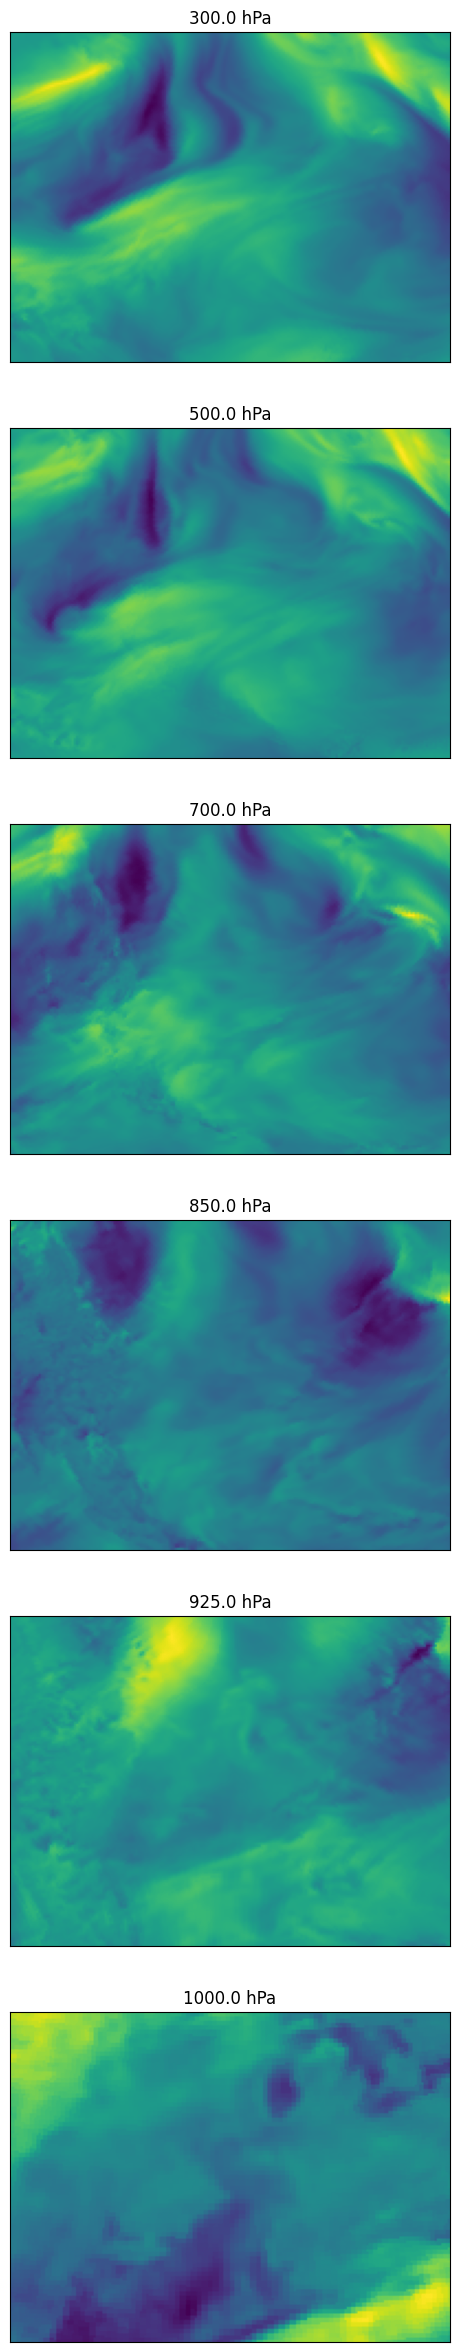

In [7]:
import matplotlib.pyplot as plt

levels = [1000.0, 925.0, 850.0, 700.0, 500.0, 300.0]
fig, axes = plt.subplots(len(levels), 1, figsize=(15, 5 * len(levels)))
axes = axes[::-1]
for i, level in enumerate(levels):
    ax = axes[i]
    ax.imshow(a[locate(U_COMPONENT_OF_WIND, level, 1)])
    ax.set_title(f"{level} hPa")
    ax.set_xticks([])
    ax.set_yticks([])